# Visual inspection of masks for border and asymmetry and possible challenges
The quality of masks will affect the results for border irregularity and asymmetry making it more challenging to separate cancerous and non cancerous lesions. Therefore, we must find more robust border and asymmetry metrics that are do not depend as much on the mask shape

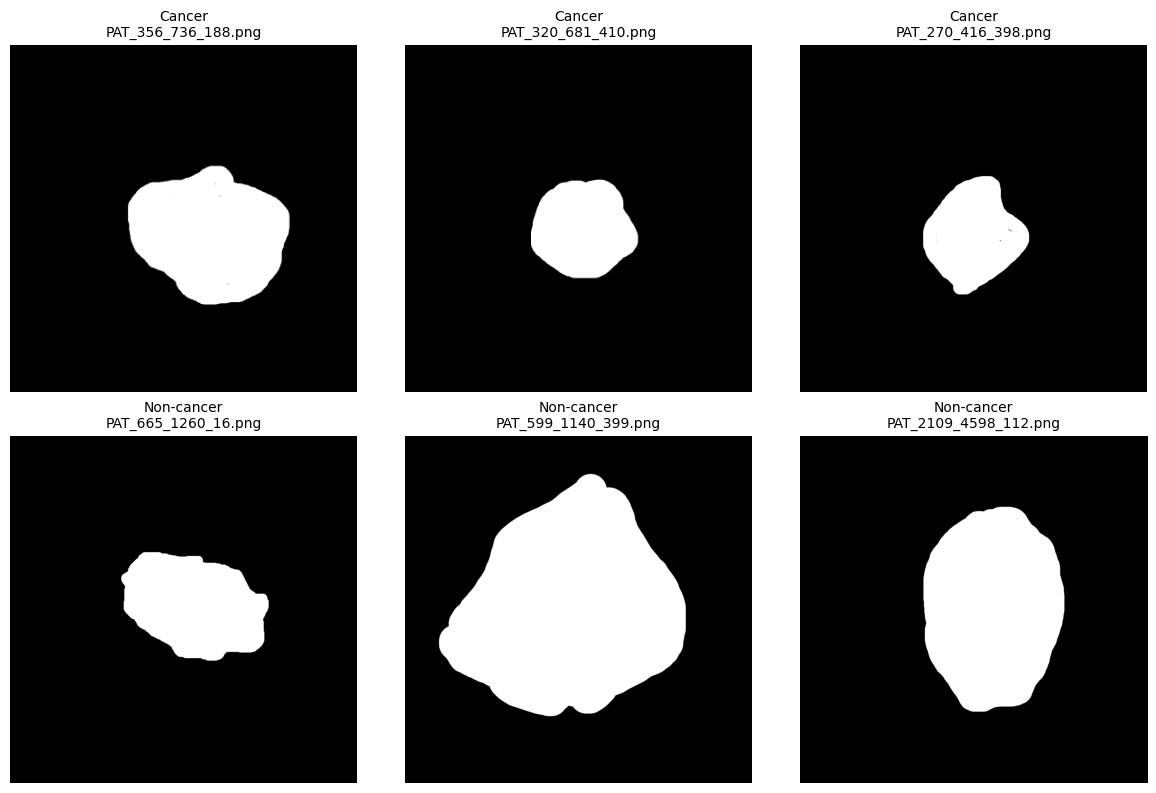

In [6]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Configuration
csv_path = 'feature_dataset.csv'          
mask_dir = './data/lesion_masks/'  

# Load dataset
df = pd.read_csv(csv_path)

# Select 3 cancerous and 3 non-cancerous randomly
cancerous = df[df['cancer'] == True].sample(3)
non_cancerous = df[df['cancer'] == False].sample(3)

# Combine into one DataFrame for plotting
samples = pd.concat([cancerous, non_cancerous]).reset_index(drop=True)

# Plotting 2x3 grid of masks
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, (_, row) in enumerate(samples.iterrows()):
    img_id = row['img_id']
    label = 'Cancer' if row['cancer'] else 'Non-cancer'

    # Construct mask path
    mask_path = os.path.join(mask_dir, img_id.replace('.png', '_mask.png'))
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print(f"Could not read mask: {mask_path}")
        continue

    # Display
    axes[i].imshow(mask, cmap='gray')
    axes[i].set_title(f"{label}\n{img_id}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

After trying out different approaches to extract border and asymmetry, we conclude that the quality of our masks limit us in findig a better separation between cancerous and non cancerous lesions. Therefore, we dont expect high AUC scores because of this serious overlap. One thing we would have done is manually work running graph cut to get better masks with all 2298 lesions, getting better masks for each. 

--- 

# 2. Border

Optimized compactness extraction - faster code

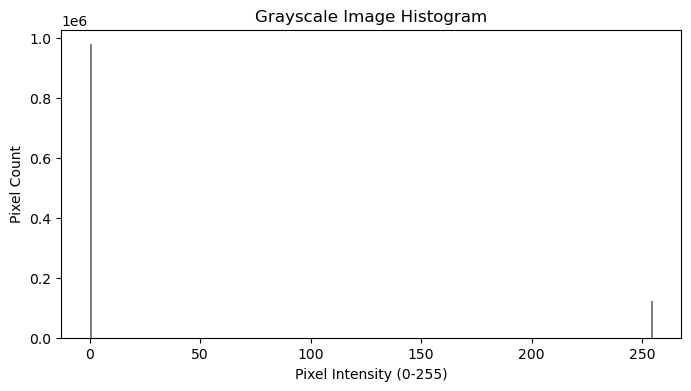

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load image as grayscale
file_im = './data/lesion_masks/PAT_8_15_820_mask.png'
im = cv2.imread(file_im, cv2.IMREAD_GRAYSCALE)

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(im.flatten(), bins=256, color='gray')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Pixel Count')
plt.title('Grayscale Image Histogram')
plt.show()

Compactness already tells how irregular the border of the image is, so no need to process the value further.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Boarder extraction feature using classical compactness formula, but optimized courner detection techniques
def B_compactness(m):
    #converting image to gray scale (remove before working with classifier) -> should be binary
    mask = cv2.imread(m, cv2.IMREAD_GRAYSCALE)
    #function used to find all detected borders, shapes
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #extracting the largest boarder, furthest from the center with largest area
    largest_contour = max(contours, key=cv2.contourArea)
    #computes euclidean distancesfor perimeter determination, close = True for closed countour shape
    perimeter = cv2.arcLength(largest_contour, closed=True)
    #calculates area using Green’s Theorem treating contour as a polygon
    area = cv2.contourArea(largest_contour)
    #calculating compactness using classical formula
    compactness = (4 * np.pi * area) / (perimeter ** 2)

    return compactness

The code that we were provided by last year students - slow running time

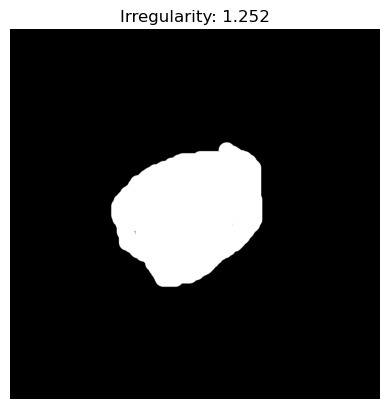

In [78]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./data/lesion_masks/PAT_8_15_820_mask.png', cv2.IMREAD_GRAYSCALE)

def measure_streaks(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #returns a list of pixels that are in the border (edge)

    lesion_area = cv2.contourArea(contours[0])
    border_perimeter = cv2.arcLength(contours[0], True) 
    if lesion_area == 0:
        irregularity = 0
    else:
        irregularity = (border_perimeter ** 2) / (4 * np.pi * lesion_area)

    return irregularity

result = measure_streaks(img)
plt.imshow(img, cmap="gray")
plt.title(f"Irregularity: {result:.3f}")
plt.axis('off')  # Optional: hides the axes
plt.show()

This number makes sense, since it is a bit irregular because perimeter exceeds area, lets try more examples and see their values

In [ ]:
# Load your DataFrame
data = pd.read_csv('feature_extraction_set.csv')

# Folder with lesion masks
mask_dir = './data/lesion_masks/'

# Initialize empty column
data['compactness'] = np.nan

# Efficient iteration
for idx, row in data.iterrows():
    base_name = row['img_base']
    mask_path = os.path.join(mask_dir, f"{base_name}_mask.png")

    if os.path.isfile(mask_path):
        try:
            score = B_compactness(mask_path)
            data.at[idx, 'compactness'] = score
        except Exception as e:
            print(f"Error at {mask_path}: {e}")
    else:
        print(f"Missing mask: {mask_path}")

In [121]:
import pandas as pd
import numpy as np
import os
import numpy as np
import cv2
from skimage import morphology

def get_compactness(mask_path):

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Convert to binary boolean mask
    mask = mask > 0  # Now it's a boolean array, as required

    area = np.sum(mask)
    if area == 0:
        return 0

    struct_el = morphology.disk(3)

    try:
        mask_eroded = morphology.binary_erosion(mask, struct_el)
        perimeter = np.sum(mask & ~mask_eroded)  # Boolean logic
    except Exception as e:
        print(f"Error processing {mask_path}: {e}")
        return 0

    if perimeter == 0:
        return 0

    return round((4 * np.pi * area) / (perimeter ** 2), 4)

In [194]:
# Load your DataFrame
data = pd.read_csv('feature_extraction_set.csv')

# Folder with lesion masks
mask_dir = './data/lesion_masks/'

# Initialize empty column
data['compactness'] = np.nan

# Efficient iteration
for idx, row in data.iterrows():
    base_name = row['img_base']
    mask_path = os.path.join(mask_dir, f"{base_name}_mask.png")

    if os.path.isfile(mask_path):
        try:
            score = B_compactness(mask_path)
            data.at[idx, 'compactness'] = score
        except Exception as e:
            print(f"Error at {mask_path}: {e}")
    else:
        print(f"Missing mask: {mask_path}")

In [189]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data['compactness_std'] = scaler.fit_transform(data[['compactness']])

In [196]:
data

diagnostic                img_id          img_base  compactness
0             1   PAT_106_159_325.png   PAT_106_159_325     0.694909
1             0   PAT_107_160_609.png   PAT_107_160_609     0.827416
2             0  PAT_289_1399_481.png  PAT_289_1399_481     0.890640
3             0     PAT_26_37_865.png     PAT_26_37_865     0.825954
4             1    PAT_98_152_562.png    PAT_98_152_562     0.795918
..          ...                   ...               ...          ...
115           1   PAT_131_197_260.png   PAT_131_197_260     0.776006
116           1   PAT_135_202_593.png   PAT_135_202_593     0.700059
117           1    PAT_90_138_605.png    PAT_90_138_605     0.781715
118           1    PAT_160_249_76.png    PAT_160_249_76     0.838848
119           0   PAT_126_192_208.png   PAT_126_192_208     0.726345

[120 rows x 4 columns]

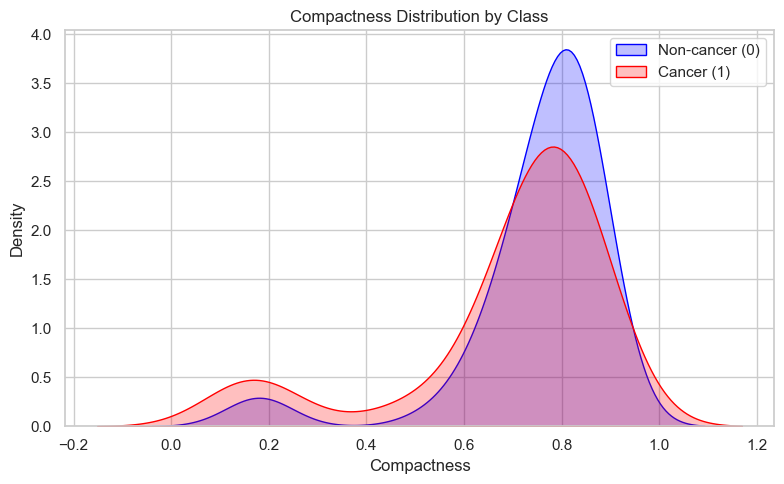

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'data' with columns 'compactness' and 'diagnostic'
plt.figure(figsize=(8, 5))
sns.kdeplot(data=data[data['diagnostic'] == 0], x='compactness', label='Non-cancer (0)', fill=True, color='blue')
sns.kdeplot(data=data[data['diagnostic'] == 1], x='compactness', label='Cancer (1)', fill=True, color='red')

plt.title('Compactness Distribution by Class')
plt.xlabel('Compactness')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# 1. Asymmetry

In [198]:
import cv2
import numpy as np
from math import floor, ceil
from skimage.transform import rotate

#Main call -> mean_asymmetry

"""Calculating asymetry score by rotating image 4 times(90 degrees) and calculating
asymetry each time"""

def cut_mask(mask):
    """Removing big part of black background to avoid misleading 
    asymetry and computational cost"""
    rows = np.any(mask, axis=1) #rows that have white pixels
    cols = np.any(mask, axis=0) #columns that have white pixels

    row_min, row_max = np.where(rows)[0][[0, -1]] #indexes of white rows
    col_min, col_max = np.where(cols)[0][[0, -1]] #indexes of white columns

    return mask[row_min:row_max+1, col_min:col_max+1] #bounding box of the lesion

def find_midpoint(image):
    """Mid point detection of the lesion, where image is grayscale mask"""
    return image.shape[0] // 2, image.shape[1] // 2 #middle row, middle column (x,y)

def asymmetry(mask):
    """Measuring shape asymetry of the mask"""
    row_mid, col_mid = find_midpoint(mask) #middle point

    #splitting the mask into 4 halves
    upper = mask[:row_mid, :]
    lower = mask[-row_mid:, :]
    left = mask[:, :col_mid]
    right = mask[:, -col_mid:]

    #flipping bottom and right half
    flipped_lower = np.flipud(lower) #flip up
    flipped_right = np.fliplr(right) #flip left

    #the following codes are used to ensure that when halves are compared,
    #the arrays have the same sizes for np.logical_xor() to work
    hmin = min(upper.shape[0], flipped_lower.shape[0]) #picks the smallest number of rows
    vmin = min(left.shape[1], flipped_right.shape[1]) #picks the smallest number of columns

    #counting mismatched pixels
    hori_xor = np.logical_xor(upper[:hmin, :], flipped_lower[:hmin, :])
    vert_xor = np.logical_xor(left[:, :vmin], flipped_right[:, :vmin])

    #calculating the area -> sum of the white pixels
    total = np.sum(mask)
    if total == 0: #if mask is black to avoid division by zero error
        return np.nan

    #calculating the asymetry score (0 perfect symetry, 1 very asymetric)
    score = (np.sum(hori_xor) + np.sum(vert_xor)) / (2 * total) 
    #total mismatch standardized by total pixels in lesion tp get score 0 to 1
    return round(score, 4)

def rotation_asymmetry(mask, n=4):
    """Rotating the picture n times and getting asymetry 
    scores for every rotation"""
    asymmetry_scores = []

    for i in range(n):
        deg = 360 * i / n
    #optimization, if the angle is multiple of 90 use np.rot90 which is faster than rotate function
        if deg % 90 == 0:
            k = int(deg // 90)
            rotated = np.rot90(mask, k)
        else:
            rotated = rotate(mask, deg, preserve_range=True, order=0).astype(np.uint8)

        cropped = cut_mask(rotated > 0)#creating a binary bounded lesion, avoiding interpolation artifacts
        score = asymmetry(cropped)
        asymmetry_scores.append(score)

    return asymmetry_scores

def mean_asymmetry(path, rotations=4):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if mask is None: #check if mask exists
        return np.nan
    mask = (mask > 0).astype(np.uint8) #binarizing because mask is in gray scale

    scores = rotation_asymmetry(mask, rotations)
    return round(np.nanmean(scores), 4)



In [199]:
# Folder with lesion masks
mask_dir = './data/lesion_masks/'

# Initialize empty column
data['asymmetry'] = np.nan

# Efficient iteration
for idx, row in data.iterrows():
    base_name = row['img_base']
    mask_path = os.path.join(mask_dir, f"{base_name}_mask.png")

    if os.path.isfile(mask_path):
        try:
            score = mean_asymmetry(mask_path)
            data.at[idx, 'asymmetry'] = score
        except Exception as e:
            print(f"Error at {mask_path}: {e}")
    else:
        print(f"Missing mask: {mask_path}")

In [200]:
data

diagnostic                img_id          img_base  compactness  \
0             1   PAT_106_159_325.png   PAT_106_159_325     0.694909   
1             0   PAT_107_160_609.png   PAT_107_160_609     0.827416   
2             0  PAT_289_1399_481.png  PAT_289_1399_481     0.890640   
3             0     PAT_26_37_865.png     PAT_26_37_865     0.825954   
4             1    PAT_98_152_562.png    PAT_98_152_562     0.795918   
..          ...                   ...               ...          ...   
115           1   PAT_131_197_260.png   PAT_131_197_260     0.776006   
116           1   PAT_135_202_593.png   PAT_135_202_593     0.700059   
117           1    PAT_90_138_605.png    PAT_90_138_605     0.781715   
118           1    PAT_160_249_76.png    PAT_160_249_76     0.838848   
119           0   PAT_126_192_208.png   PAT_126_192_208     0.726345   

     asymmetry  
0       0.1232  
1       0.1024  
2       0.0380  
3       0.0887  
4       0.0646  
..         ...  
115     0.0900  
116     0.1231  
117     0.0981  
118     0.1156  
119     0.2503  

[120 rows x 5 columns]

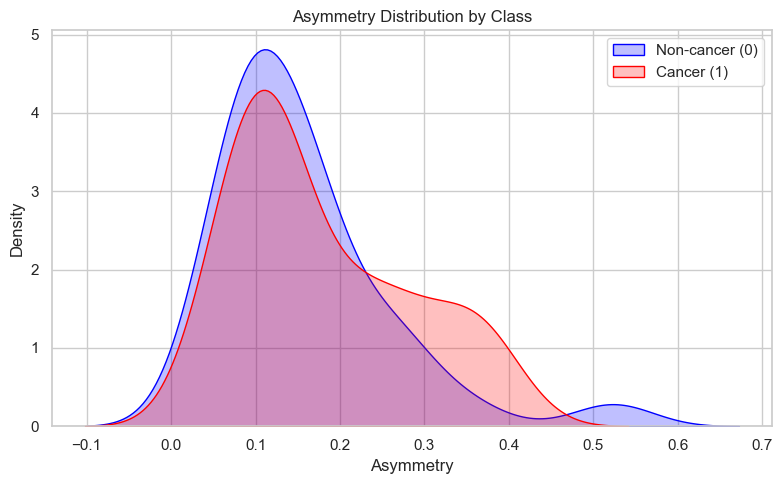

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'data' with columns 'compactness' and 'diagnostic'
plt.figure(figsize=(8, 5))
sns.kdeplot(data=data[data['diagnostic'] == 0], x='asymmetry', label='Non-cancer (0)', fill=True, color='blue')
sns.kdeplot(data=data[data['diagnostic'] == 1], x='asymmetry', label='Cancer (1)', fill=True, color='red')

plt.title('Asymmetry Distribution by Class')
plt.xlabel('Asymmetry')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

---
# 3. Color

In [ ]:
import pandas as pd
import numpy as np
import os
import numpy as np
import cv2
from util.feature_C import slic_segmentation, get_color_vector

# Load DataFrame
data = pd.read_csv('feature_extraction_set.csv')

# Folder with lesion masks
img_dir = './data/imgs_part_1/'
mask_dir = './data/lesion_masks/'
downsizing_factor = 0.4

# Initialize empty column
data['color'] = None

# Efficient iteration
for idx, row in data.iterrows():
    img_path = os.path.join(img_dir, f"{row['img_id']}")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (int(img.shape[1] * downsizing_factor), int(img.shape[0] * downsizing_factor)), interpolation=cv2.INTER_AREA) #key step to improve running time

    mask_path = os.path.join(mask_dir, f"{row['img_base']}_mask.png")
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (int(mask.shape[1] * downsizing_factor), int(mask.shape[0] * downsizing_factor)), interpolation=cv2.INTER_NEAREST) #key step to improve running time

    vector = slic_segmentation(img, mask, n_segments=25, compactness=0.5)
    data.at[idx, 'color'] = True

data

diagnostic                img_id          img_base color
0             1   PAT_106_159_325.png   PAT_106_159_325  True
1             0   PAT_107_160_609.png   PAT_107_160_609  True
2             0  PAT_289_1399_481.png  PAT_289_1399_481  True
3             0     PAT_26_37_865.png     PAT_26_37_865  True
4             1    PAT_98_152_562.png    PAT_98_152_562  True
..          ...                   ...               ...   ...
115           1   PAT_131_197_260.png   PAT_131_197_260  True
116           1   PAT_135_202_593.png   PAT_135_202_593  True
117           1    PAT_90_138_605.png    PAT_90_138_605  True
118           1    PAT_160_249_76.png    PAT_160_249_76  True
119           0   PAT_126_192_208.png   PAT_126_192_208  True

[120 rows x 4 columns]

We see that the running time of slic_algorithm with previous downsampling is pretty good, an average of 17 seconds for 120 images which gives an average of 0.14 s per image. We now need to perform the whole vector extraction to see whats the running time, and evaluate correctness.

In [57]:
import pandas as pd
import numpy as np
import os
import numpy as np
import cv2
from util.feature_C import get_color_vector

# Load DataFrame
data = pd.read_csv('feature_extraction_set.csv')

# Folder with lesion masks
img_dir = './data/imgs_part_1/'
mask_dir = './data/lesion_masks/'

# Initialize empty column
data['color'] = None

# Efficient iteration
for idx, row in data.iterrows():
    img_path = os.path.join(img_dir, f"{row['img_id']}")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask_path = os.path.join(mask_dir, f"{row['img_base']}_mask.png")
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    vector = get_color_vector(img, mask, n_segments=30, compactness=0.1, kasmi_threshold=0.4)
    data.at[idx, 'color'] = vector

data

diagnostic                img_id          img_base  \
0             1   PAT_106_159_325.png   PAT_106_159_325   
1             0   PAT_107_160_609.png   PAT_107_160_609   
2             0  PAT_289_1399_481.png  PAT_289_1399_481   
3             0     PAT_26_37_865.png     PAT_26_37_865   
4             1    PAT_98_152_562.png    PAT_98_152_562   
..          ...                   ...               ...   
115           1   PAT_131_197_260.png   PAT_131_197_260   
116           1   PAT_135_202_593.png   PAT_135_202_593   
117           1    PAT_90_138_605.png    PAT_90_138_605   
118           1    PAT_160_249_76.png    PAT_160_249_76   
119           0   PAT_126_192_208.png   PAT_126_192_208   

                                                 color  
0    [0.0, 0.0, 0.3076923076923077, 0.4615384615384...  
1    [0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.94...  
2                       [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
3    [0.0, 0.15384615384615385, 0.07692307692307693...  
4    [0.2727272727272727, 0.0, 0.0, 0.0, 0.0, 0.727...  
..                                                 ...  
115                   [0.0, 0.0, 0.0, 0.75, 0.0, 0.25]  
116  [0.14285714285714285, 0.0, 0.0, 0.142857142857...  
117  [0.0, 0.0, 0.3333333333333333, 0.3333333333333...  
118                     [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]  
119  [0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.83...  

[120 rows x 4 columns]

Randomly pick images and see if the numbers make sense 

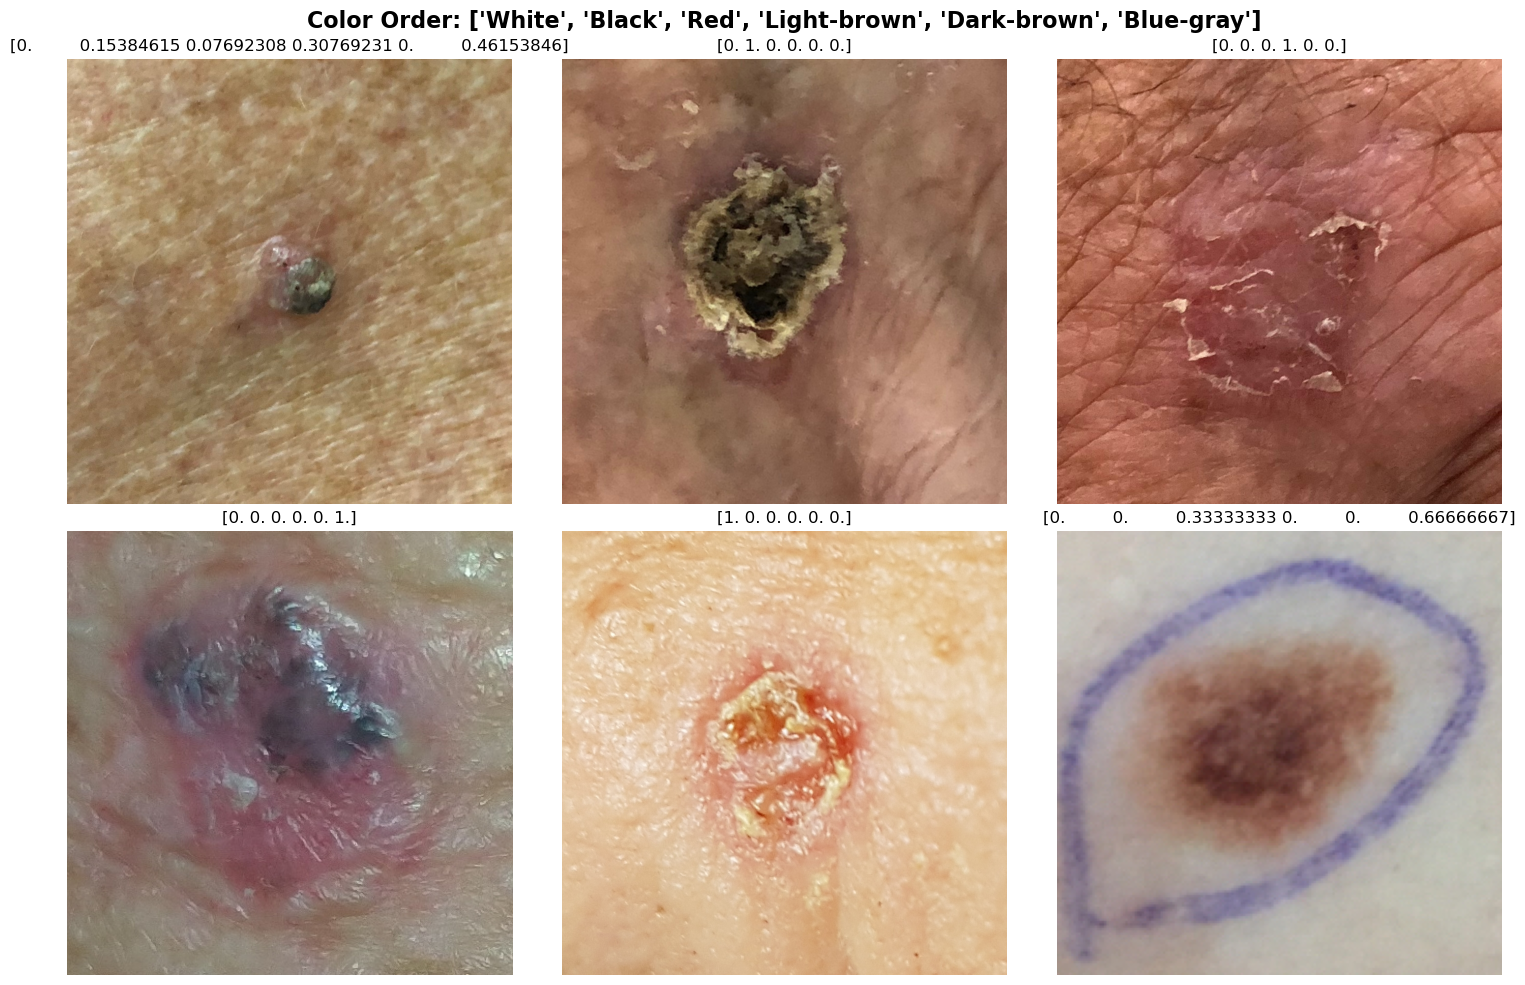

In [58]:
#evaluating if the values in color vector make sense through visual inspection

import matplotlib.pyplot as plt
import cv2
import numpy as np

# Randomly select 6 positions
img_dir = './data/imgs_part_1/'
random_samples = data.sample(6)

# Set up the figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Color Order: ['White', 'Black', 'Red', 'Light-brown', 'Dark-brown', 'Blue-gray']", fontsize=16, fontweight='bold')
axes = axes.flatten()

# Display each image with vector as title
for ax, (_, row) in zip(axes, random_samples.iterrows()):
    img_path = os.path.join(img_dir, f"{row['img_id']}")
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax.imshow(img_rgb)
    ax.set_title(f"{row['color']}")
    ax.axis('off')

plt.tight_layout()
plt.show()


After many random visual inspections, the algorithm throws reasonable numbers and with a very good running time!!!
Approximately 25 s to process 120 images, which gives an average of 0.2083 seconds per image

In [59]:
# Define color labels in Kasmi order
color_labels = ['white', 'black', 'red', 'light_brown', 'dark_brown', 'blue_gray']

# Convert the 'color' column into a DataFrame with six separate columns
color_df = pd.DataFrame(data['color'].tolist(), columns=color_labels)

# Concatenate this back with the original DataFrame
data_better = pd.concat([data.drop(columns=['color']), color_df], axis=1)
data_better

diagnostic                img_id          img_base     white     black  \
0             1   PAT_106_159_325.png   PAT_106_159_325  0.000000  0.000000   
1             0   PAT_107_160_609.png   PAT_107_160_609  0.055556  0.000000   
2             0  PAT_289_1399_481.png  PAT_289_1399_481  1.000000  0.000000   
3             0     PAT_26_37_865.png     PAT_26_37_865  0.000000  0.153846   
4             1    PAT_98_152_562.png    PAT_98_152_562  0.272727  0.000000   
..          ...                   ...               ...       ...       ...   
115           1   PAT_131_197_260.png   PAT_131_197_260  0.000000  0.000000   
116           1   PAT_135_202_593.png   PAT_135_202_593  0.142857  0.000000   
117           1    PAT_90_138_605.png    PAT_90_138_605  0.000000  0.000000   
118           1    PAT_160_249_76.png    PAT_160_249_76  0.000000  0.000000   
119           0   PAT_126_192_208.png   PAT_126_192_208  0.166667  0.000000   

          red  light_brown  dark_brown  blue_gray  
0    0.307692     0.461538    0.230769   0.000000  
1    0.000000     0.000000    0.000000   0.944444  
2    0.000000     0.000000    0.000000   0.000000  
3    0.076923     0.307692    0.000000   0.461538  
4    0.000000     0.000000    0.000000   0.727273  
..        ...          ...         ...        ...  
115  0.000000     0.750000    0.000000   0.250000  
116  0.000000     0.142857    0.000000   0.714286  
117  0.333333     0.333333    0.333333   0.000000  
118  0.000000     1.000000    0.000000   0.000000  
119  0.000000     0.000000    0.000000   0.833333  

[120 rows x 9 columns]

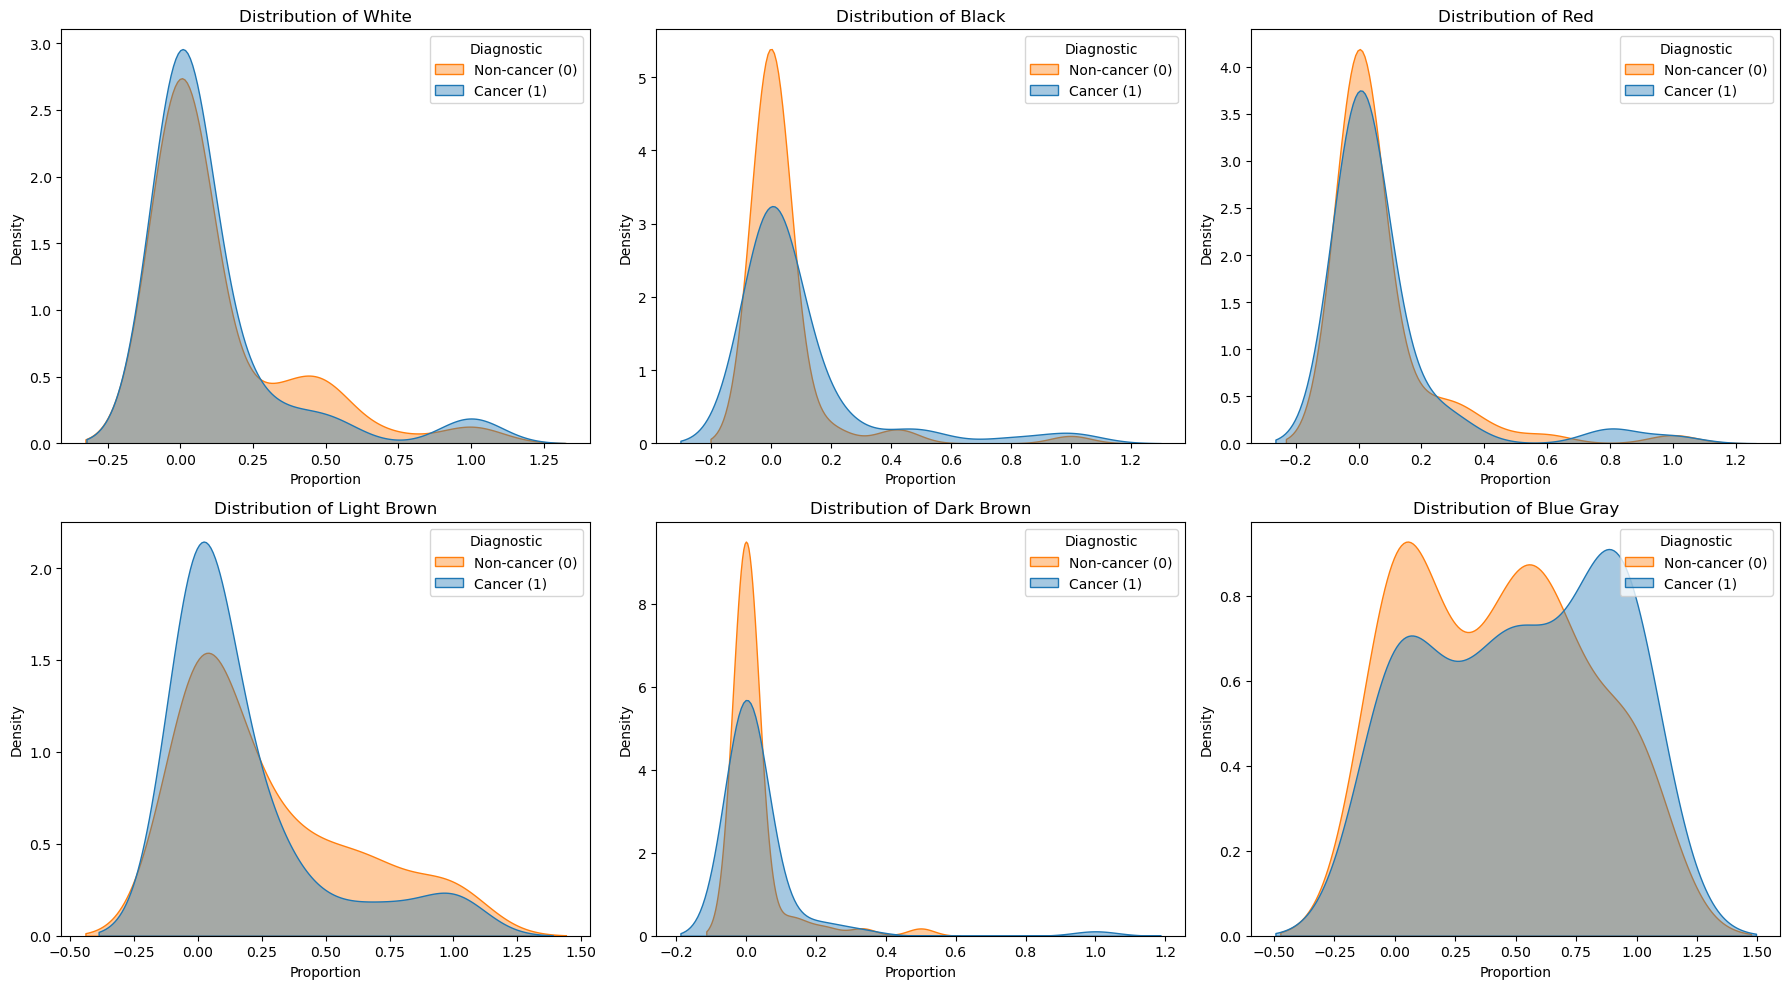

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of color feature names
color_features = ['white', 'black', 'red', 'light_brown', 'dark_brown', 'blue_gray']

# Set up the figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot each color feature
for i, color in enumerate(color_features):
    sns.kdeplot(data=data_better, x=color, hue='diagnostic', common_norm=False, fill=True, alpha=0.4, ax=axes[i])
    axes[i].set_title(f"Distribution of {color.replace('_', ' ').title()}")
    axes[i].set_xlabel('Proportion')
    axes[i].set_ylabel('Density')
    axes[i].legend(title='Diagnostic', labels=['Non-cancer (0)', 'Cancer (1)'])

plt.tight_layout()
plt.show()


We see some separability patterns, such as blue_gray, higher proportions of black and dark brown in canerous lesions. This is a good sign, meaning that a combination of all color proportions plus border and asymmetry values will probably give good predictions.

## Issue

After trying different models, this proportion vector approach doesnt seem to be really insightfull especially because we get a lot of 0's which makes the classes non-separable. We now consider a mean HSV approach and a std dev HSV approach to see if that provides better separability of cancer vs non cancer. This might be better because we will have numbers in a continuous range, and more specific number for each data point as well. 

In [22]:
import pandas as pd
import numpy as np
import os
import numpy as np
import cv2

import importlib
import util.feature_C
importlib.reload(util.feature_C)
from util.feature_C import get_color_vector

import pandas as pd
import numpy as np
import os
import cv2
from util.feature_C import get_color_vector

# Load DataFrame
data = pd.read_csv('feature_extraction_set.csv')

# Folder paths
img_dir = './data/imgs/'
mask_dir = './data/lesion_masks/'

# Store all results as list of dictionaries
color_features = []

# Efficient iteration
for idx, row in data.iterrows():
    img_path = os.path.join(img_dir, f"{row['img_id']}")
    mask_path = os.path.join(mask_dir, f"{row['img_base']}_mask.png")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    vector = get_color_vector(img, mask, n_segments=50, compactness=0.1, kasmi_threshold=0.4)

    vector['diagnostic'] = row['diagnostic']
    vector['img_id'] = row['img_id']
    vector['img_base'] = row['img_base']

    color_features.append(vector)

# to datafame
color_df = pd.DataFrame(color_features)

color_df.head()

mean_H     std_H    mean_S     std_S    mean_V     std_V  White  \
0  0.010722  0.009371  0.627380  0.094773  0.535336  0.032600    0.0   
1  0.128137  0.080891  0.216457  0.123236  0.540594  0.058300    0.0   
2  0.920090  0.017300  0.129148  0.023612  0.711967  0.023278    1.0   
3  0.089174  0.031858  0.356207  0.085005  0.457252  0.121452    0.0   
4  0.003737  0.036625  0.239706  0.125403  0.687916  0.053163    0.5   

      Black       Red  Light-brown  Dark-brown  Blue-gray  diagnostic  \
0  0.000000  0.933333          0.0         0.0   0.066667           1   
1  0.476190  0.000000          0.0         0.0   0.142857           0   
2  0.000000  0.000000          0.0         0.0   0.000000           0   
3  0.764706  0.000000          0.0         0.0   0.058824           0   
4  0.000000  0.000000          0.0         0.0   0.416667           1   

                 img_id          img_base  
0   PAT_106_159_325.png   PAT_106_159_325  
1   PAT_107_160_609.png   PAT_107_160_609  
2  PAT_289_1399_481.png  PAT_289_1399_481  
3     PAT_26_37_865.png     PAT_26_37_865  
4    PAT_98_152_562.png    PAT_98_152_562

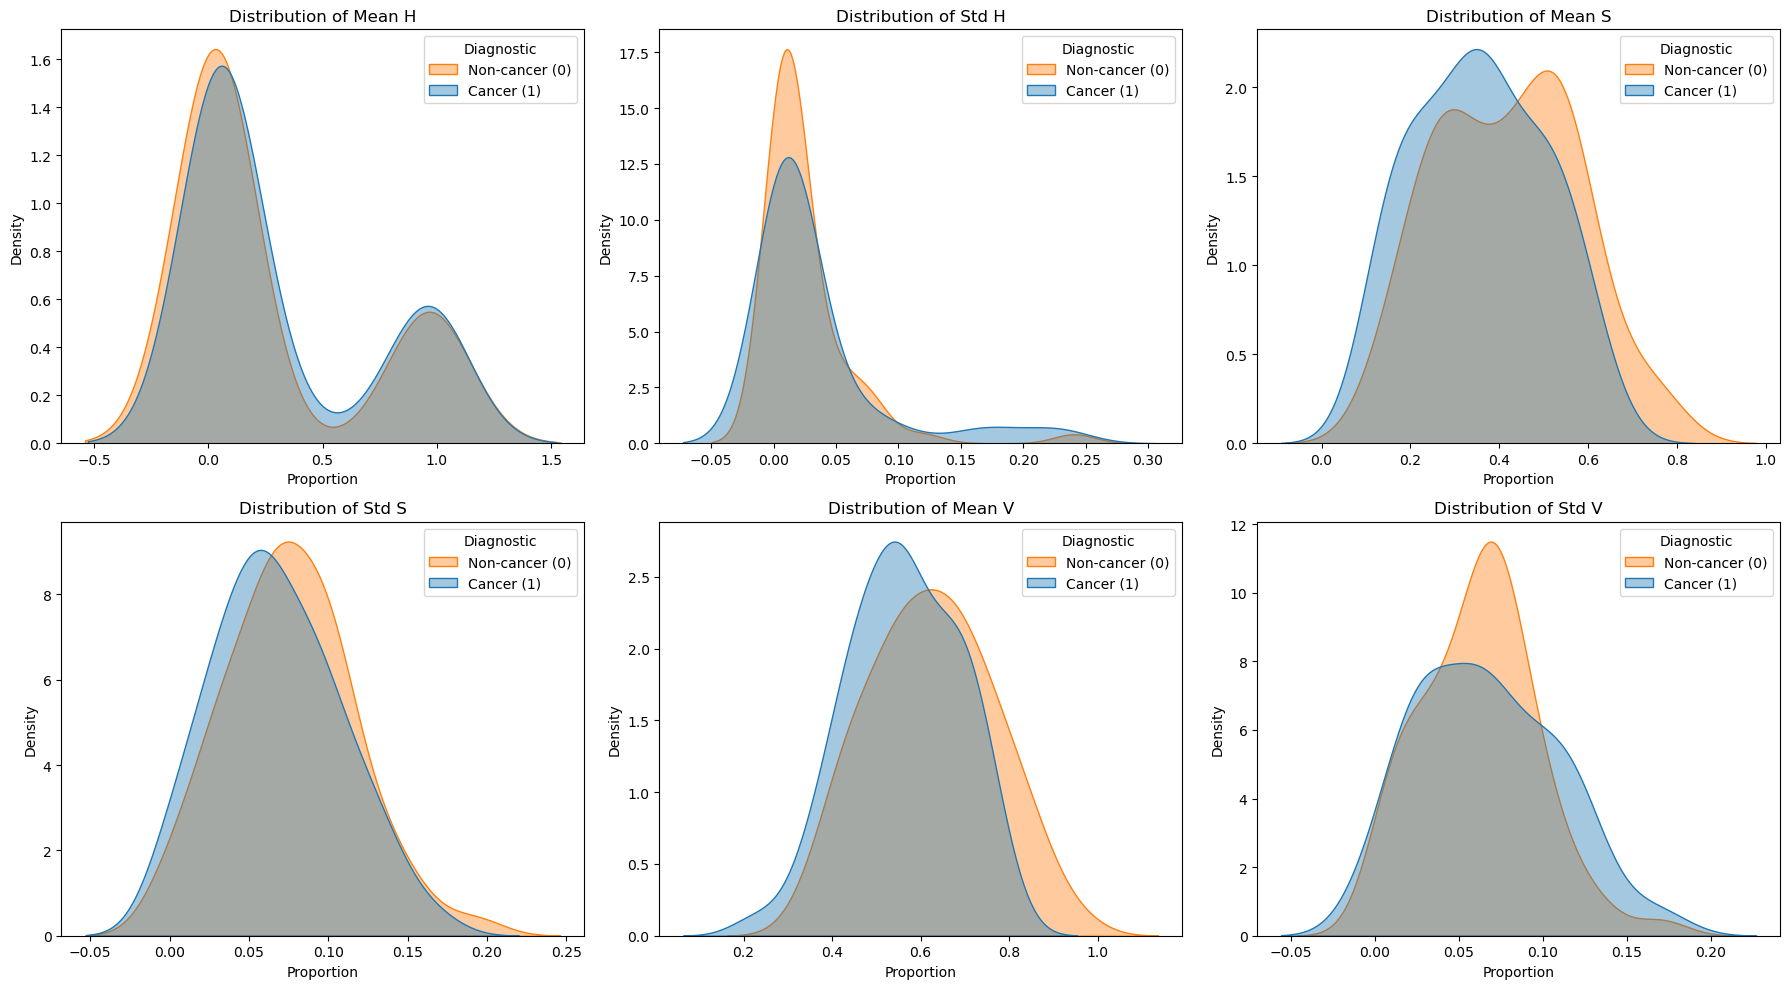

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of color feature names
color_features = ['mean_H', 'std_H', 'mean_S', 'std_S', 'mean_V', 'std_V']

# Set up the figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot each color feature
for i, color in enumerate(color_features):
    sns.kdeplot(data=color_df, x=color, hue='diagnostic', common_norm=False, fill=True, alpha=0.4, ax=axes[i])
    axes[i].set_title(f"Distribution of {color.replace('_', ' ').title()}")
    axes[i].set_xlabel('Proportion')
    axes[i].set_ylabel('Density')
    axes[i].legend(title='Diagnostic', labels=['Non-cancer (0)', 'Cancer (1)'])

plt.tight_layout()
plt.show()

- Mean H: The bimodal distribution for both lesions suggests two dominant color type, probably reddish and blue gray tones.

- Std H: Cancerous lesions seem to have a longer right tail, suggesting more hue irregularity in some cases, which is expectable, since cancerous lesions tend to have multiple colors.

- Mean S: There's some separation, non-cancerous lesions are slightly more saturated. Cancerous lesions may have more muted or varied pigmentation.

- Std S: Almost overlapping, but cancerous lesions show a wider spread, another hint of irregularity.

- Mean V: Slightly lower brightness in cancerous lesions — potentially due to darker pigmentation.

- Std V: Slightly higher for cancer, supporting the idea of irregular shading or color variation.

### Image Enhancement?
This suggests that a slight image enhancement technique might be even better to help differentiate both classes. We'll try an HSV histogram equalization version of the original grayscale histogram equalization (**CLAHE** ). Considering we want to improve contrast, we'll change the V channel of the HSV image. Lets try it with 3 random images and observe the results.

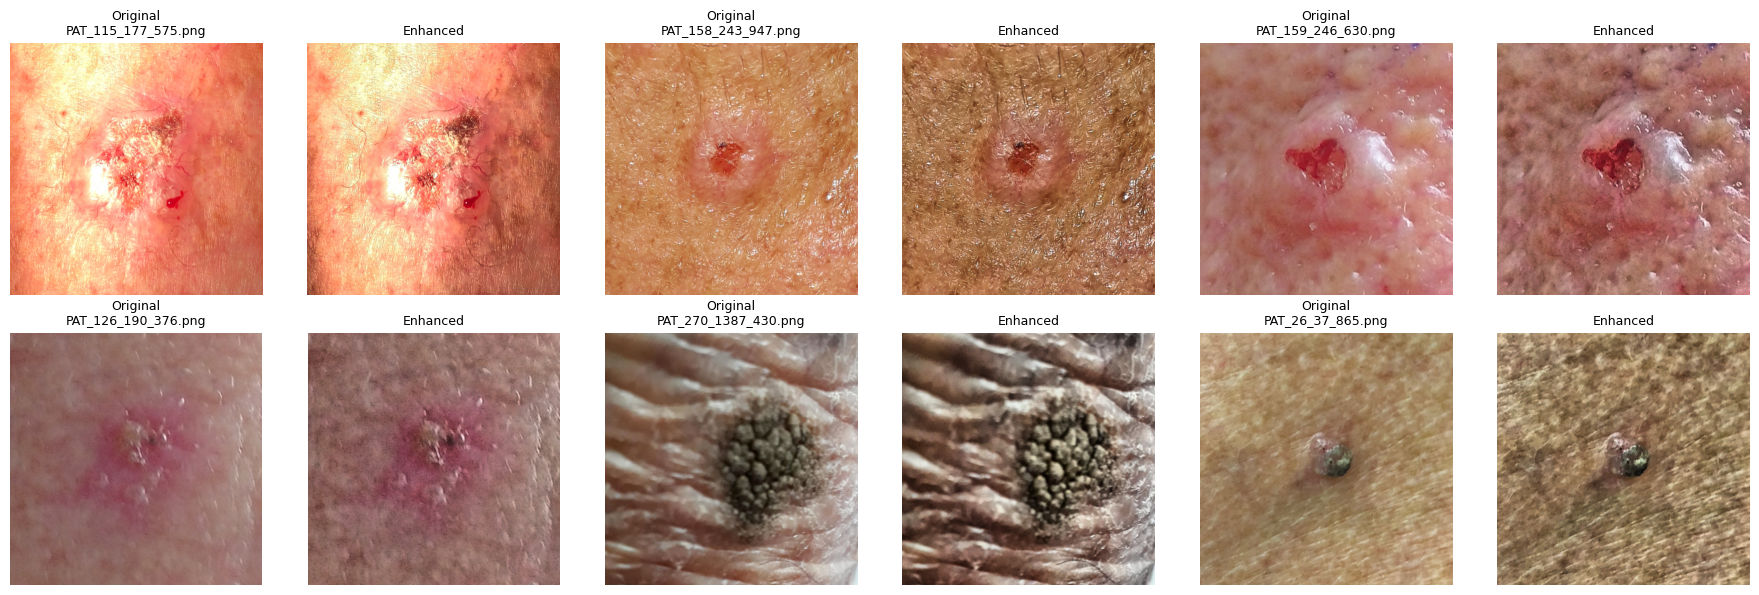

In [45]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def enhance_color_hsv_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    v_enhanced = clahe.apply(v)

    hsv_enhanced = cv2.merge([h, s, v_enhanced])
    enhanced_image = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2RGB)
    return enhanced_image

img_dir = './data/imgs/'  

cancerous = color_df[color_df['diagnostic'] == 1].sample(n=3)
non_cancerous = color_df[color_df['diagnostic'] == 0].sample(n=3)

samples = pd.concat([cancerous, non_cancerous]).reset_index(drop=True)

fig, axes = plt.subplots(2, 6, figsize=(18, 6))
axes = axes.flatten()

for i, (_, row) in enumerate(samples.iterrows()):
    img_path = os.path.join(img_dir, row['img_id'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    enhanced_img = enhance_color_hsv_clahe(img)

    # Display original
    axes[2 * i].imshow(img)
    axes[2 * i].set_title(f"Original\n{row['img_id']}", fontsize=9)
    axes[2 * i].axis('off')

    # Display enhanced
    axes[2 * i + 1].imshow(enhanced_img)
    axes[2 * i + 1].set_title("Enhanced", fontsize=9)
    axes[2 * i + 1].axis('off')

plt.tight_layout()
plt.show()


### Analysis
These results look promising. Lets add this preprocessing step before feature extraction and observe changes in mean_V and std_V distributions!

In [28]:
import pandas as pd
import numpy as np
import os
import numpy as np
import cv2

import importlib
import util.feature_C
importlib.reload(util.feature_C)
from util.feature_C import get_color_vector

# Load DataFrame
data = pd.read_csv('feature_extraction_set.csv')

# Folder paths
img_dir = './data/imgs/'
mask_dir = './data/lesion_masks/'

# Store all results as list of dictionaries
color_features = []

# image enhancement function
def enhance_color_hsv_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    v_enhanced = clahe.apply(v)

    hsv_enhanced = cv2.merge([h, s, v_enhanced])
    enhanced_image = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2RGB)
    return enhanced_image


# Efficient iteration
for idx, row in data.iterrows():
    img_path = os.path.join(img_dir, f"{row['img_id']}")
    mask_path = os.path.join(mask_dir, f"{row['img_base']}_mask.png")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = enhance_color_hsv_clahe(img) #image preprocessing step before feature extractions

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    vector = get_color_vector(img, mask, n_segments=50, compactness=0.1, kasmi_threshold=0.4)

    vector['diagnostic'] = row['diagnostic']
    vector['img_id'] = row['img_id']
    vector['img_base'] = row['img_base']

    color_features.append(vector)

# to datafame
color_df = pd.DataFrame(color_features)

color_df.head()

mean_H     std_H    mean_S     std_S    mean_V     std_V  White  \
0  0.007951  0.007660  0.656636  0.114723  0.491454  0.080362  0.000   
1  0.121163  0.066454  0.242375  0.130903  0.519296  0.093997  0.000   
2  0.931604  0.010127  0.132158  0.031199  0.608611  0.041817  0.000   
3  0.088287  0.034438  0.364679  0.088899  0.422133  0.147010  0.000   
4  0.023913  0.029713  0.301317  0.130226  0.588746  0.080615  0.125   

      Black       Red  Light-brown  Dark-brown  Blue-gray  diagnostic  \
0  0.000000  0.900000          0.0         0.0      0.100           1   
1  0.625000  0.000000          0.0         0.0      0.000           0   
2  0.000000  0.000000          0.0         0.0      1.000           0   
3  0.833333  0.083333          0.0         0.0      0.000           0   
4  0.125000  0.125000          0.0         0.0      0.625           1   

                 img_id          img_base  
0   PAT_106_159_325.png   PAT_106_159_325  
1   PAT_107_160_609.png   PAT_107_160_609  
2  PAT_289_1399_481.png  PAT_289_1399_481  
3     PAT_26_37_865.png     PAT_26_37_865  
4    PAT_98_152_562.png    PAT_98_152_562

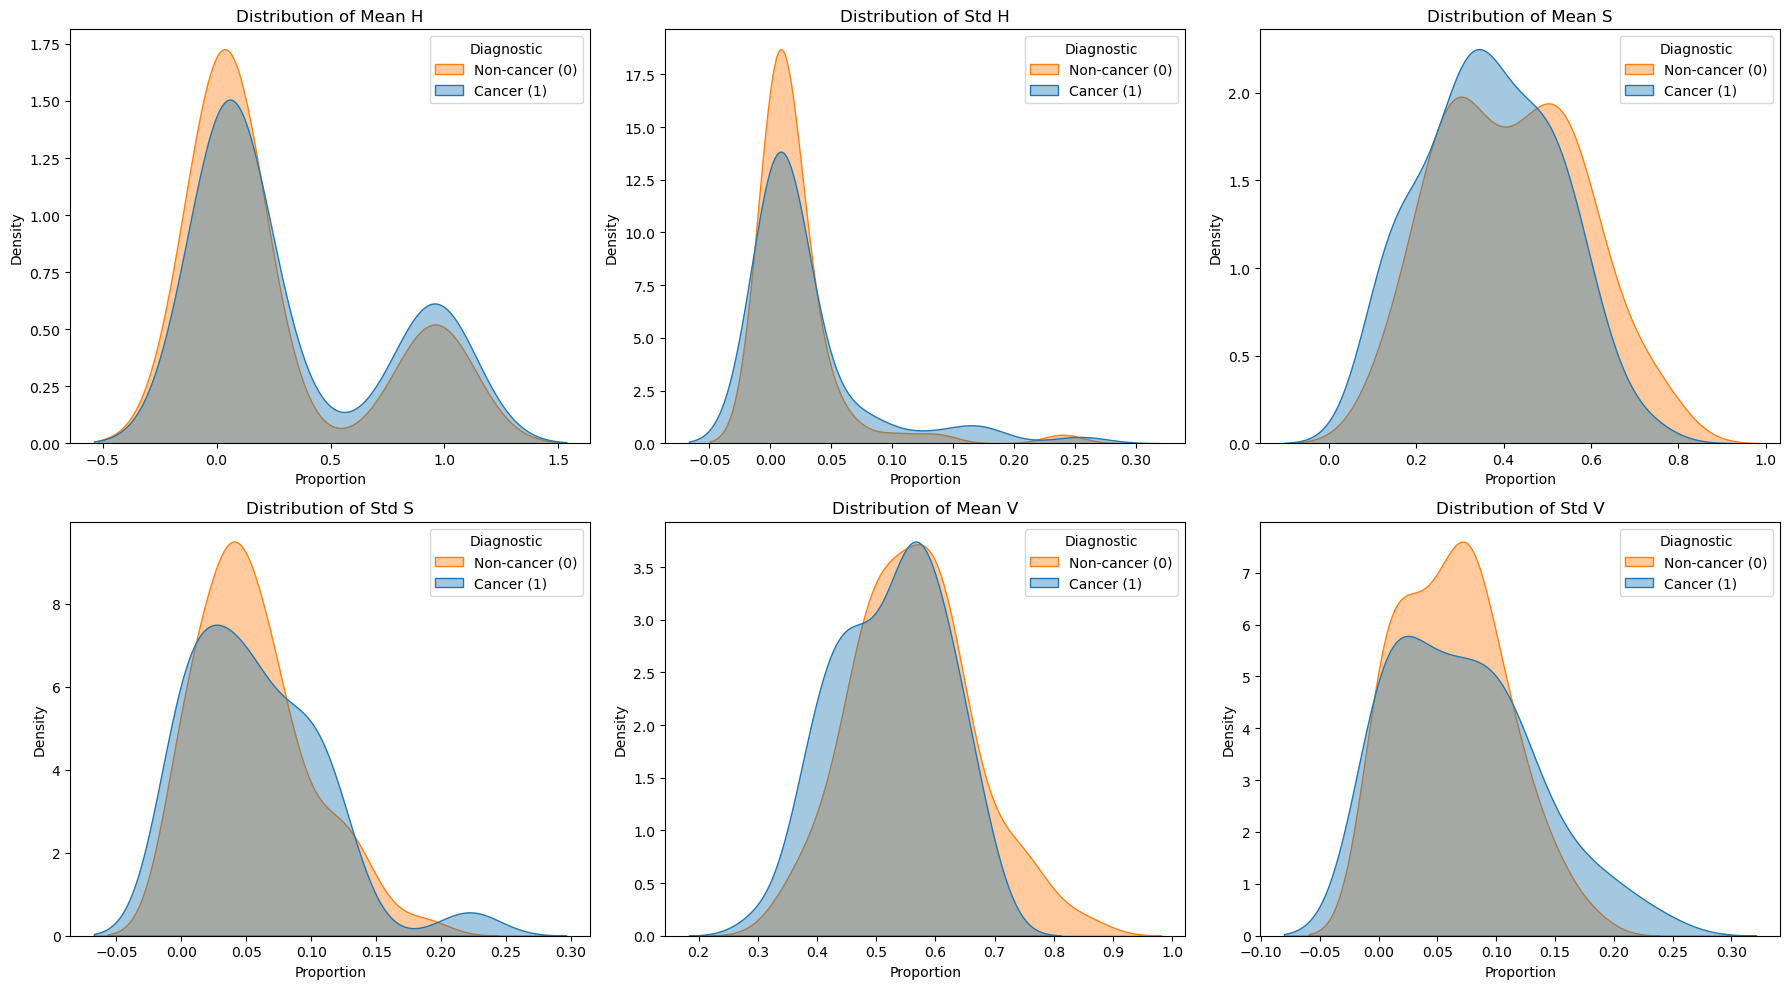

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of color feature names
color_features = ['mean_H', 'std_H', 'mean_S', 'std_S', 'mean_V', 'std_V']

# Set up the figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot each color feature
for i, color in enumerate(color_features):
    sns.kdeplot(data=color_df, x=color, hue='diagnostic', common_norm=False, fill=True, alpha=0.4, ax=axes[i])
    axes[i].set_title(f"Distribution of {color.replace('_', ' ').title()}")
    axes[i].set_xlabel('Proportion')
    axes[i].set_ylabel('Density')
    axes[i].legend(title='Diagnostic', labels=['Non-cancer (0)', 'Cancer (1)'])

plt.tight_layout()
plt.show()

- Mean V: 
    - Before enhancement: The distributions for cancerous and non-cancerous lesions overlap more.
    - After enhancement: There's a clearer shift between the two — especially the cancer class shifts left (darker?), potentially increasing separability.

- Std V:
    - Before enhancement: Distributions are tighter, with more overlap.
    - After enhancement: The spread is slightly wider for the cancer group, suggesting increased contrast, which is good.

- Saturation (Mean S / Std S):
    - After enhancement, the means shift slightly apart. If enhancement amplifies real differences in lesion pigmentation, this could help classifiers pick up subtle saturation cues.

I'll now extract all the features from my image dataset and check classifier performance -> AUC above 70%

### Considering color is the most trustworthy feature, we try to exploit it as much as possible:
    - Test color entropy
    - Test number of dominant colors

### ENTROPY

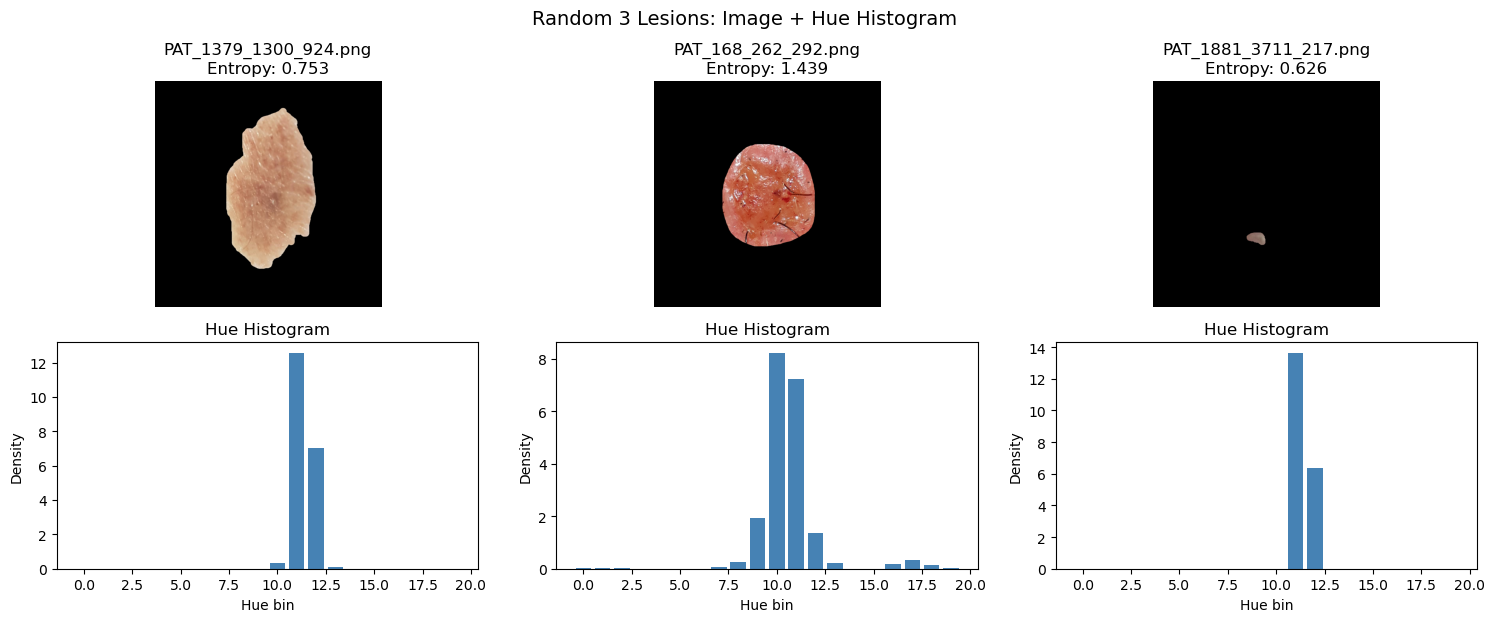

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.color import rgb2hsv
from scipy.stats import entropy
import random
import os


img_folder = './data/imgs/'             
mask_folder = './data/lesion_masks/'    
dataset_path = 'correct_mask_list.csv'         


def hue_histogram_entropy(image, mask, bins=20):
    hsv = rgb2hsv(image)
    hue = hsv[:, :, 0][mask > 0]
    hist, _ = np.histogram(hue, bins=bins, range=(0, 1), density=True)
    return hist, entropy(hist + 1e-6)  # Add epsilon to avoid log(0)


df = pd.read_csv(dataset_path)
samples = df.sample(3)


fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()

for i, (_, row) in enumerate(samples.iterrows()):
    img_path = os.path.join(img_folder, row['Filename'])
    mask_path = os.path.join(mask_folder, row['Filename'].replace('.png', '_mask.png'))

    
    img = cv2.imread(img_path)
    img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = rgb2hsv(img_color)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    
    masked_img = img_color.copy()
    masked_img[mask == 0] = 0

    
    hist, ent = hue_histogram_entropy(img, mask)

    # Plot image
    axes[i].imshow(masked_img)
    axes[i].axis('off')
    axes[i].set_title(f"{row['Filename']}\nEntropy: {ent:.3f}")

    # Plot histogram
    axes[i + 3].bar(range(len(hist)), hist, color='steelblue')
    axes[i + 3].set_title("Hue Histogram")
    axes[i + 3].set_xlabel('Hue bin')
    axes[i + 3].set_ylabel('Density')

plt.tight_layout()
plt.suptitle("Random 3 Lesions: Image + Hue Histogram", fontsize=14, y=1.03)
plt.show()


Entropy is working as desired: it increases with hue variation inside the lesion.  
Lesions with more homogeneous hues (for example light pink or brown uniformly) score lower on entropy.  
Lesions with multiple competing color areas (dark spots, borders, reddish patches) score higher.

### Comparing Hue Standard Deviation vs Entropy

### Standard Deviation (std) of HSV
- **What it measures**: Spread of hue values around the mean.
- **Useful for**: Capturing how much color varies across the lesion.
- **Limitation**:
  - Assumes a unimodal, symmetric distribution.
  - Cannot detect if variation comes from distinct color regions vs gradual shading.
  - Fails to describe the *shape* or *structure* of the color distribution.

---

### Entropy of Hue Histogram
- **What it measures**: Uncertainty or randomness in the hue distribution.
- **Useful for**: Capturing color *complexity* or *irregularity*.
- **Strengths**:
  - Detects **multimodal distributions** (e.g., lesions with multiple distinct colors).
  - Sensitive to *how balanced* the hue values are across the lesion.
  - Reflects how diverse or "patchy" the lesion's color appearance is.

---

### Examples

- Smooth red gradient has high std but low entropy: broad range but monotone color
- Red patch and brown patch have medium std but high entropy because the histogram will have two "peaks" even though they are pretty close to each other.
- Mostly brown with a few bright specs will give high std deviation and low entropy, a few outliers will inflate std but the overall color is simple

---

- **Std deviation** captures overall spread.
- **Entropy** captures structural irregularity and color diversity.
- Using both helps distinguish between:
  - Smooth but varied lesions.
  - Chaotic or patchy lesions.
  - Homogeneous color regions.

They complement each other and together give a more nuanced picture of lesion color complexity.

## NO. DOMINANT COLORS  
Since the feature_C function has just been updated to work on hue entropy and dominant colors, i will import the whole function and evaluate on the no. of dominant colors obtained.

In [6]:
import importlib
import util.feature_C
importlib.reload(util.feature_C)
from util.feature_C import get_color_vector

import pandas as pd
import numpy as np
import os
import numpy as np
import cv2

# Load DataFrame
data = pd.read_csv('feature_extraction_set.csv')

# Folder paths
img_dir = './data/imgs/'
mask_dir = './data/lesion_masks/'

# Store all results as list of dictionaries
color_features = []

# image enhancement function
def enhance_color_hsv_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    v_enhanced = clahe.apply(v)

    hsv_enhanced = cv2.merge([h, s, v_enhanced])
    enhanced_image = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2RGB)
    return enhanced_image


# Efficient iteration
for idx, row in data.iterrows():
    img_path = os.path.join(img_dir, f"{row['img_id']}")
    mask_path = os.path.join(mask_dir, f"{row['img_base']}_mask.png")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = enhance_color_hsv_clahe(img)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    vector = get_color_vector(img, mask, n_segments=50, compactness=0.1)

    vector['diagnostic'] = row['diagnostic']
    vector['img_id'] = row['img_id']
    vector['img_base'] = row['img_base']

    color_features.append(vector)

# to datafame
color_df = pd.DataFrame(color_features)

color_df.head()

mean_H     std_H    mean_S     std_S    mean_V     std_V  color_entropy  \
0  0.010722  0.009371  0.627380  0.094773  0.535336  0.032600       0.392688   
1  0.128137  0.080891  0.216457  0.123236  0.540594  0.058300       1.073841   
2  0.920090  0.017300  0.129148  0.023612  0.711967  0.023278       0.000015   
3  0.089174  0.031858  0.356207  0.085005  0.457252  0.121452       0.605811   
4  0.003737  0.036625  0.239706  0.125403  0.687916  0.053163       0.636527   

   dominant_colors  diagnostic                img_id          img_base  
0                2           1   PAT_106_159_325.png   PAT_106_159_325  
1                3           0   PAT_107_160_609.png   PAT_107_160_609  
2                2           0  PAT_289_1399_481.png  PAT_289_1399_481  
3                2           0     PAT_26_37_865.png     PAT_26_37_865  
4                4           1    PAT_98_152_562.png    PAT_98_152_562

In [4]:
np.unique(color_df['dominant_colors'])

array([1, 2, 3, 4, 5, 6], dtype=int64)

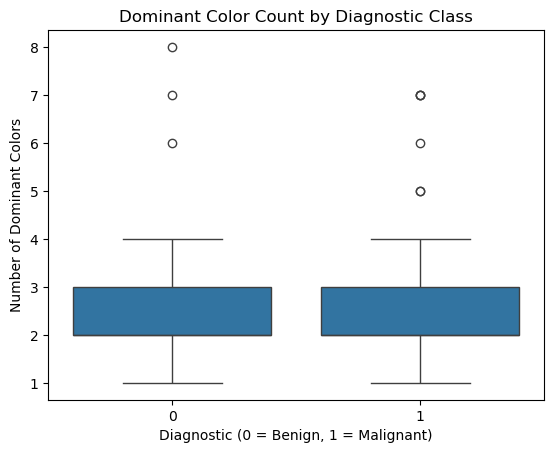

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='diagnostic', y='dominant_colors', data=color_df)
plt.title("Dominant Color Count by Diagnostic Class")
plt.xlabel("Diagnostic (0 = Benign, 1 = Malignant)")
plt.ylabel("Number of Dominant Colors")
plt.show()

This doesn't seem to work because it doesn't add class separability. I'll try to focus on number of melanoma colors present. Also the running time of this is not really good.

In [1]:
import importlib
import util.feature_C
importlib.reload(util.feature_C)
from util.feature_C import get_color_vector

import pandas as pd
import numpy as np
import os
import numpy as np
import cv2

data = pd.read_csv('feature_extraction_set.csv')

img_dir = './data/imgs/'
mask_dir = './data/lesion_masks/'

color_features = []

# image enhancement function
def enhance_color_hsv_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    v_enhanced = clahe.apply(v)

    hsv_enhanced = cv2.merge([h, s, v_enhanced])
    enhanced_image = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2RGB)
    return enhanced_image


for idx, row in data.iterrows():
    img_path = os.path.join(img_dir, f"{row['img_id']}")
    mask_path = os.path.join(mask_dir, f"{row['img_base']}_mask.png")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = enhance_color_hsv_clahe(img)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    vector = get_color_vector(img, mask, n_segments=50, compactness=0.1)

    vector['diagnostic'] = row['diagnostic']
    vector['img_id'] = row['img_id']
    vector['img_base'] = row['img_base']

    color_features.append(vector)

# to datafame
color_df = pd.DataFrame(color_features)

color_df.head()

mean_H     std_H    mean_S     std_S    mean_V     std_V  \
0  0.010722  0.009371  0.627380  0.094773  0.535336  0.032600   
1  0.128137  0.080891  0.216457  0.123236  0.540594  0.058300   
2  0.920090  0.017300  0.129148  0.023612  0.711967  0.023278   
3  0.089174  0.031858  0.356207  0.085005  0.457252  0.121452   
4  0.003737  0.036625  0.239706  0.125403  0.687916  0.053163   

   melanoma_colors  diagnostic                img_id          img_base  
0                2           1   PAT_106_159_325.png   PAT_106_159_325  
1                2           0   PAT_107_160_609.png   PAT_107_160_609  
2                1           0  PAT_289_1399_481.png  PAT_289_1399_481  
3                2           0     PAT_26_37_865.png     PAT_26_37_865  
4                2           1    PAT_98_152_562.png    PAT_98_152_562

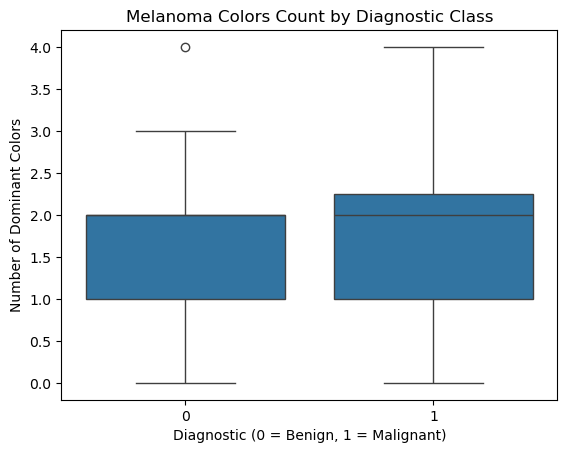

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='diagnostic', y='melanoma_colors', data=color_df)
plt.title("Melanoma Colors Count by Diagnostic Class")
plt.xlabel("Diagnostic (0 = Benign, 1 = Malignant)")
plt.ylabel("Number of Dominant Colors")
plt.show()

In [3]:
#testing a simple classifier to obvserve the AUC scores and significance of this feature
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X = color_df[['melanoma_colors']]
y = color_df['diagnostic']

model = LogisticRegression()
scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print(f"Mean AUC: {scores.mean():.3f}")

Mean AUC: 0.433


The number of melanoma colors isn't predictive (worse than guessing). Let's try it together with other features mean HSV and std dev HSV.

### Trying out if they work better as a group (entropy/melanoma_colors + number of melanoma colors)


In [5]:
import importlib
import util.feature_C
importlib.reload(util.feature_C)
from util.feature_C import get_color_vector

import pandas as pd
import numpy as np
import os
import numpy as np
import cv2

data = pd.read_csv('feature_extraction_set.csv')

img_dir = './data/imgs/'
mask_dir = './data/lesion_masks/'

color_features = []

# image enhancement function
def enhance_color_hsv_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    v_enhanced = clahe.apply(v)

    hsv_enhanced = cv2.merge([h, s, v_enhanced])
    enhanced_image = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2RGB)
    return enhanced_image


for idx, row in data.iterrows():
    img_path = os.path.join(img_dir, f"{row['img_id']}")
    mask_path = os.path.join(mask_dir, f"{row['img_base']}_mask.png")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = enhance_color_hsv_clahe(img)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    vector = get_color_vector(img, mask, n_segments=50, compactness=0.1)

    vector['diagnostic'] = row['diagnostic']
    vector['img_id'] = row['img_id']
    vector['img_base'] = row['img_base']

    color_features.append(vector)

# to datafame
color_df = pd.DataFrame(color_features)

color_df.head()

mean_H     std_H    mean_S     std_S    mean_V     std_V  color_entropy  \
0  0.010722  0.009371  0.627380  0.094773  0.535336  0.032600       0.392688   
1  0.128137  0.080891  0.216457  0.123236  0.540594  0.058300       1.073841   
2  0.920090  0.017300  0.129148  0.023612  0.711967  0.023278       0.000015   
3  0.089174  0.031858  0.356207  0.085005  0.457252  0.121452       0.605811   
4  0.003737  0.036625  0.239706  0.125403  0.687916  0.053163       0.636527   

   melanoma_colors  diagnostic                img_id          img_base  
0                2           1   PAT_106_159_325.png   PAT_106_159_325  
1                2           0   PAT_107_160_609.png   PAT_107_160_609  
2                1           0  PAT_289_1399_481.png  PAT_289_1399_481  
3                2           0     PAT_26_37_865.png     PAT_26_37_865  
4                2           1    PAT_98_152_562.png    PAT_98_152_562

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

X = color_df[['color_entropy', 'melanoma_colors', 'mean_H', 'std_H', 'mean_S', 'std_S', 'mean_V', 'std_V']]
y = color_df['diagnostic']

print("KNN AUCs:")
for k in [1, 3, 5, 7, 9, 12, 15]:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f"k={k}: AUC = {scores.mean():.3f}")


KNN AUCs:
k=1: AUC = 0.542
k=3: AUC = 0.596
k=5: AUC = 0.626
k=7: AUC = 0.597
k=9: AUC = 0.617
k=12: AUC = 0.564
k=15: AUC = 0.577


Numbers are better than mean HSV and std dev HSV alone. So adding melanoma_colors might provide better separation of classes.  
After adding number of melanoma colors + color entropy gives the highest numbers at k=5

In [53]:
from sklearn.tree import DecisionTreeClassifier

X = color_df[['color_entropy', 'melanoma_colors', 'mean_H', 'std_H', 'mean_S', 'std_S', 'mean_V', 'std_V']]
y = color_df['diagnostic']

for depth in [1, 2, 3, 5, 7, 10, None]:
    model = DecisionTreeClassifier(max_depth=depth, random_state=0)
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f"Tree depth={depth}: AUC = {scores.mean():.3f}")

Tree depth=1: AUC = 0.575
Tree depth=2: AUC = 0.616
Tree depth=3: AUC = 0.581
Tree depth=5: AUC = 0.486
Tree depth=7: AUC = 0.592
Tree depth=10: AUC = 0.533
Tree depth=None: AUC = 0.533


Some of these numbers seem promising, its maybe a good sign that we should try it out on a bigger dataser using HSV + entropy + melanoma_colors features!

### Testing out entropy: does it work better over superpixels, or pixels in general?

In [ ]:
import importlib
import util.feature_C
importlib.reload(util.feature_C)
from util.feature_C import get_color_vector

import pandas as pd
import numpy as np
import os
import numpy as np
import cv2

data = pd.read_csv('feature_extraction_set.csv')

img_dir = './data/imgs/'
mask_dir = './data/lesion_masks/'

color_features = []

# image enhancement function
def enhance_color_hsv_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    v_enhanced = clahe.apply(v)

    hsv_enhanced = cv2.merge([h, s, v_enhanced])
    enhanced_image = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2RGB)
    return enhanced_image


for idx, row in data.iterrows():
    img_path = os.path.join(img_dir, f"{row['img_id']}")
    mask_path = os.path.join(mask_dir, f"{row['img_base']}_mask.png")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = enhance_color_hsv_clahe(img)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    vector = get_color_vector(img, mask, n_segments=50, compactness=0.1)

    vector['diagnostic'] = row['diagnostic']
    vector['img_id'] = row['img_id']
    vector['img_base'] = row['img_base']

    color_features.append(vector)

# to datafame
color_df = pd.DataFrame(color_features)

color_df.head()

mean_H     std_H    mean_S     std_S    mean_V     std_V  \
0  0.010722  0.009371  0.627380  0.094773  0.535336  0.032600   
1  0.128137  0.080891  0.216457  0.123236  0.540594  0.058300   
2  0.920090  0.017300  0.129148  0.023612  0.711967  0.023278   
3  0.089174  0.031858  0.356207  0.085005  0.457252  0.121452   
4  0.003737  0.036625  0.239706  0.125403  0.687916  0.053163   

   color_entropy_sup  color_entropy  melanoma_colors  diagnostic  \
0           0.392688       0.542940                2           1   
1           1.073841       1.718803                2           0   
2           0.000015       1.474600                1           0   
3           0.605811       1.003962                2           0   
4           0.636527       1.280923                2           1   

                 img_id          img_base  
0   PAT_106_159_325.png   PAT_106_159_325  
1   PAT_107_160_609.png   PAT_107_160_609  
2  PAT_289_1399_481.png  PAT_289_1399_481  
3     PAT_26_37_865.png     PAT_26_37_865  
4    PAT_98_152_562.png    PAT_98_152_562

In [50]:
color_df.tail()

mean_H     std_H    mean_S     std_S    mean_V     std_V  \
115  0.018295  0.005917  0.561951  0.091421  0.643166  0.073967   
116  0.962533  0.024383  0.444983  0.064385  0.684839  0.076242   
117  0.013382  0.012101  0.718653  0.137466  0.530431  0.082645   
118  0.024955  0.016467  0.523433  0.106199  0.483537  0.067472   
119  0.910599  0.080947  0.158801  0.055210  0.615214  0.029306   

     color_entropy_sup  color_entropy  melanoma_colors  diagnostic  \
115           0.000015       0.450357                2           1   
116           0.348846       0.888622                3           1   
117           0.336509       0.473322                3           1   
118           0.450575       0.407341                2           1   
119           1.159580       1.873375                2           0   

                  img_id         img_base  
115  PAT_131_197_260.png  PAT_131_197_260  
116  PAT_135_202_593.png  PAT_135_202_593  
117   PAT_90_138_605.png   PAT_90_138_605  
118   PAT_160_249_76.png   PAT_160_249_76  
119  PAT_126_192_208.png  PAT_126_192_208

Even though the entropy values are expected to be lower in superpixels, some numbers are not consistent, suggesting the superpixel approach might be too oversimplified.

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

X = color_df[['color_entropy', 'mean_H', 'std_H', 'mean_S', 'std_S', 'mean_V', 'std_V']]
y = color_df['diagnostic']

print("KNN AUCs:")
for k in [1, 3, 5, 7, 9, 12, 15]:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f"k={k}: AUC = {scores.mean():.3f}")

KNN AUCs:
k=1: AUC = 0.558
k=3: AUC = 0.506
k=5: AUC = 0.471
k=7: AUC = 0.522
k=9: AUC = 0.534
k=12: AUC = 0.588
k=15: AUC = 0.593


The model is worse with color entropy pixel approach!

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

X = color_df[['color_entropy_sup', 'mean_H', 'std_H', 'mean_S', 'std_S', 'mean_V', 'std_V']]
y = color_df['diagnostic']

print("KNN AUCs:")
for k in [1, 3, 5, 7, 9, 12, 15]:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f"k={k}: AUC = {scores.mean():.3f}")

KNN AUCs:
k=1: AUC = 0.592
k=3: AUC = 0.537
k=5: AUC = 0.478
k=7: AUC = 0.512
k=9: AUC = 0.512
k=12: AUC = 0.547
k=15: AUC = 0.567


In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

X = color_df[['color_entropy', 'mean_H', 'std_H', 'mean_S', 'std_S', 'mean_V', 'std_V']]
y = color_df['diagnostic']

print("KNN AUCs:")
for k in [1, 3, 5, 7, 9, 12, 15]:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f"k={k}: AUC = {scores.mean():.3f}")

KNN AUCs:
k=1: AUC = 0.558
k=3: AUC = 0.506
k=5: AUC = 0.471
k=7: AUC = 0.522
k=9: AUC = 0.534
k=12: AUC = 0.588
k=15: AUC = 0.593


In [62]:
from sklearn.tree import DecisionTreeClassifier

X = color_df[['color_entropy', 'melanoma_colors', 'mean_H', 'std_H', 'mean_S', 'std_S', 'mean_V', 'std_V']]
y = color_df['diagnostic']

for depth in [1, 2, 3, 5, 7, 10, None]:
    model = DecisionTreeClassifier(max_depth=depth, random_state=0)
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f"Tree depth={depth}: AUC = {scores.mean():.3f}")

Tree depth=1: AUC = 0.575
Tree depth=2: AUC = 0.616
Tree depth=3: AUC = 0.581
Tree depth=5: AUC = 0.486
Tree depth=7: AUC = 0.592
Tree depth=10: AUC = 0.533
Tree depth=None: AUC = 0.533


In [63]:
from sklearn.tree import DecisionTreeClassifier

X = color_df[['color_entropy_sup', 'melanoma_colors', 'mean_H', 'std_H', 'mean_S', 'std_S', 'mean_V', 'std_V']]
y = color_df['diagnostic']

for depth in [1, 2, 3, 5, 7, 10, None]:
    model = DecisionTreeClassifier(max_depth=depth, random_state=0)
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f"Tree depth={depth}: AUC = {scores.mean():.3f}")

Tree depth=1: AUC = 0.592
Tree depth=2: AUC = 0.520
Tree depth=3: AUC = 0.559
Tree depth=5: AUC = 0.537
Tree depth=7: AUC = 0.580
Tree depth=10: AUC = 0.542
Tree depth=None: AUC = 0.542


We will try the entropy pixel based model, which makes more sense conceptually and seems to give more consistent numbers in cross validation.